# Data Science project: CIRI

## Imports

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import pickle
import tqdm
import os
import re

from enum import Enum
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from PIL import Image

## Parameters

In [2]:
# Whether model descriptors should be extracted for the baseline (True), or
# loaded from the filesystem (False)
extract_model_descriptors = False

## Generic setup

Set the device. Using CUDA on CUDA-enabled devices speeds up the use of convolutional networks significantly.

In [3]:
cuda_enabled = torch.cuda.is_available()
device = torch.device("cuda:1" if cuda_enabled else "cpu")

We will be using a random number generator every now and then throughout this notebook. By initializing it here, we can change a single seed to obtain the same/different results.

In [4]:
rng = np.random.default_rng(0)

We create the descriptors through transfer learning. We remove the last fully-connected (classification) layers of pre-trained models and use the output of the convolutional part of the respective model as descriptors. We do this for:

- VGG16

These models were chosen because of ... **TODO: List reasons for choosing models**

## Load datasets

Because the dataset contains images with a filename starting with a dot ("."), these files are hidden, giving problems down the line with reading. As such, rename them by adding "img" as a filename prefix.

In [5]:
base_path = "./data/Incidents-subset"
directories = os.listdir(os.path.expanduser(base_path))
for directory in directories:
    files = os.listdir(os.path.expanduser(base_path + "/" + directory))
    for file in files:
        if re.match(r".*.((jpg)|(png)|(jpeg))", file, re.IGNORECASE) and not re.match(r"img.*", file):
            os.rename(os.path.expanduser(base_path + "/" + directory + "/" + file), os.path.expanduser(base_path + "/" + directory + "/img" + file))

Some images are corrupted, so we need a check whether this is the case before images are added to the dataset. This is done by calling the function below in the `is_valid_file` parameter of the `ImageFolder` function.

In [6]:
def check_Image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False

For transformation and normalization, we use the same parameter as used in the paper source code.

> Weber, E., Papadopoulos, D.P., Lapedriza, A., Ofli, F., Imran, M. and Torralba, A. 2022. Incidents1M: a large-scale dataset of images with natural disasters, damage, and incidents. arXiv.

Source code: https://github.com/ethanweber/IncidentsDataset.


In [7]:
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize,
])

data = torchvision.datasets.ImageFolder(
    './data/Incidents-subset',
    transform=transform,
    is_valid_file=check_Image
)

Next, we split the data into a train and test set.

In [8]:
class DataType(Enum):
    TRAIN = "train"
    TEST = "test"


class Dataset:
    """
    Represents a dataset from which data, targets and dataloaders can be easily
    extracted. Used mostly as a Data Transfer Object to reduce the need to pass
    high numbers of parameters.
    """

    def __init__(self, data, ratios):
        """
        Keyword arguments:
        data   -- torch Dataset
        ratios -- labels mapped to the portion of the dataset the corresponding
                  subset should entail
        """
        self.all_data = data
        self.all_targets = self._get_targets(data)
        self.all_classes = data.classes

        data_splits = torch.utils.data.random_split(data, list(ratios.values()))
        labels = ratios.keys()

        self.data = {}
        for i, label in enumerate(labels):
            self.data[label] = data_splits[i]

        self.targets = {}
        for label, data in self.data.items():
            self.targets[label] = self._get_targets(data)

        self.dataloaders = {}
        for label, data in self.data.items():
            self.dataloaders[label] = DataLoader(data, batch_size=4, shuffle=False)

    def _get_targets(self, data):
        return [target for (_, target) in data]


dataset = Dataset(data, {DataType.TRAIN: 0.7, DataType.TEST: 0.3})

/home/jovyan/2022-1B-DS-CIRI-Project/env/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


## Visualise datasets

### General information

In [9]:
print(f"Number of items in dataset: {len(dataset.all_data)}")
print(f"Number of items in train set: {len(dataset.data[DataType.TRAIN])}")
print(f"Number of images in test set: {len(dataset.data[DataType.TEST])}")
print(f"Number of classes: {len(dataset.all_classes)}")

Number of items in dataset: 7363
Number of items in train set: 5155
Number of images in test set: 2208
Number of classes: 12


### Class distribution

First, we assess the number of images per class in both the train and test set. This provides us with a rough idea of the distribution in the dataset.

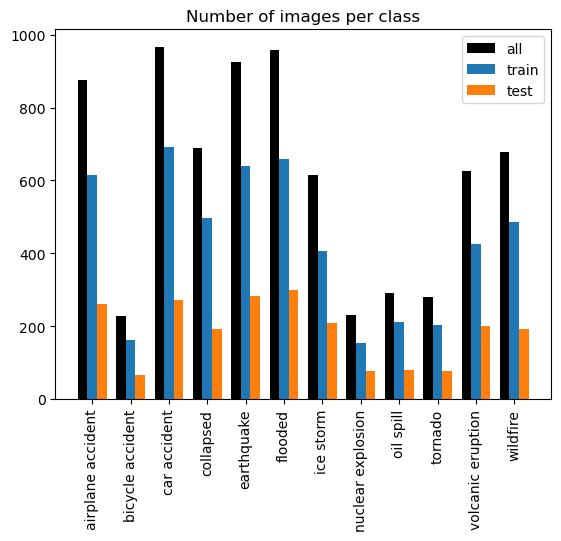

In [10]:
unique_targets, unique_target_counts = np.unique(
    dataset.all_targets,
    return_counts=True
)
unique_targets_train, unique_target_counts_train = np.unique(
    dataset.targets[DataType.TRAIN],
    return_counts=True
)
unique_targets_test, unique_target_counts_test = np.unique(
    dataset.targets[DataType.TEST],
    return_counts=True
)

# Assert that train and test set both contain the same number of classes, as subsequent code relies on this assumption
assert len(unique_targets_train) == len(dataset.all_classes), "Train set must contain all classes"
assert len(unique_targets_test) == len(dataset.all_classes), "Test set must contain all classes"

# Convoluted way of showing a bar chart with multiple bars, but prevents having to create a dataframe for e.g. Seaborn
plt.bar(np.arange(len(dataset.all_classes)) - 0.25,
        unique_target_counts,
        width=0.25,
        label="all",
        color="black")
plt.bar(np.arange(len(dataset.all_classes)),
        unique_target_counts_train,
        width=0.25,
        # color="none",
        # edgecolor="black",
        # hatch="----",
        label="train")
plt.bar(np.arange(len(dataset.all_classes)) + 0.25,
        unique_target_counts_test,
        width=0.25,
        # color="none",
        # edgecolor="black",
        label="test")
plt.xticks(np.arange(len(dataset.all_classes)),
           labels=dataset.all_classes,
           rotation="vertical")
plt.legend()
plt.title("Number of images per class")
plt.show()

The plot shows that the data in the dataset is unbalanced. For example, the "car accident" class sees a much larger occurence than the "nuclear explosion" class. This could lead to issues later on.

### Sample images

As a result of the normalization performed earlier, the images cannot be displayed as-is without clipping. Hence, we need a way to inverse the normalization before displaying the images. We do this through the use of a `Transform`.

In [11]:
class NormalizeInverse(torchvision.transforms.Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    Code from https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821/8
    """

    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())


inverse_normalize = NormalizeInverse(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

Now, we actually visualise the images.

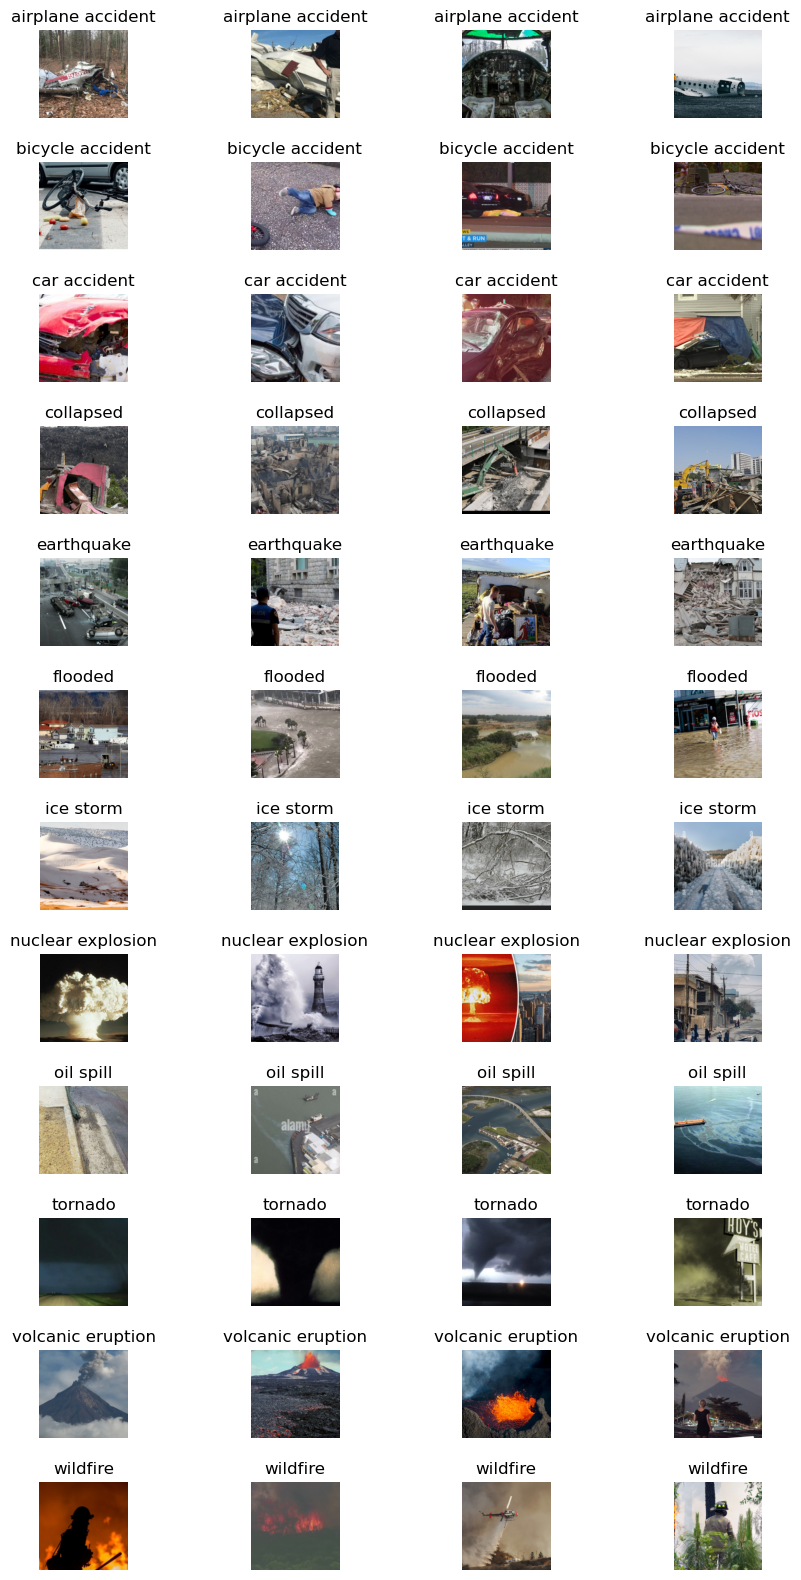

In [12]:
number_of_images_per_class = 4

# Create plots with sufficient size and spacing
fig, axs = plt.subplots(len(dataset.all_classes),
                        number_of_images_per_class,
                        figsize=(10, 20))
plt.subplots_adjust(hspace=.5, wspace=.5)

for target_class in range(0, len(dataset.all_classes)):
    # Create a mask for the dataset to include only images for this class
    relevant_image_indices = (np.array(dataset.all_targets) == target_class).nonzero()[0]

    # Randomly sample images from all relevant images
    sampled_image_indices = rng.choice(
        a=relevant_image_indices,
        size=number_of_images_per_class,
        replace=False
    )

    # Display the images with the proper title
    for i, image_index in enumerate(sampled_image_indices):
        ax = axs[target_class, i]
        ax.imshow(
            # Clamp to prevent values just outside the [0,1] range (as a result of inverse normalisation)
            torch.clamp(inverse_normalize(dataset.all_data[image_index][0]).permute(1,2,0), 0, 1),
            vmin=0,
            vmax=1)
        ax.axis("off")
        ax.set_title(dataset.all_classes[target_class])

## Initialize models

In [13]:
class Model():
    """
    Represents a generic convolutional model that is used for transfer
    learning, from which descriptors can be extracted for classification.
    """
    def __init__(self, model, name):
        self.model = model
        self.name = name

        for param in self.model.parameters():
            # As the model will not be trained, gradients are not required.
            # Disabling them speeds up performance.
            param.requires_grad = False

        self.model.eval()
        self.remove_classifier()

    def remove_classifier(self):
        """
        Removes the last fully connected layer (the classifier) from the
        model, allowing the extraction of descriptors.
        """
        raise NotImplementedError()

    def to(self, device):
        self.model = self.model.to(device)

    def descriptors(self, dataloader, as_numpy=True):
        """
        Returns the output of the model for all items in the dataloader.
        """
        outputs = []
        with torch.no_grad():
            for data, targets in tqdm.tqdm(dataloader):
                data = data.to(device)
                output = self.model(data).detach()
                outputs.extend(output)

        if as_numpy:
            outputs = np.array([output.cpu().numpy() for output in outputs])

        return outputs


models = []
if cuda_enabled:
    torch.cuda.empty_cache()

### VGG16

In [14]:
class Vgg16Model(Model):
    def __init__(self):
        model = torchvision.models.vgg16(weights="DEFAULT")
        super().__init__(model, "VGG16")

    def remove_classifier(self):
        self.model.classifier = nn.Identity()


vgg16 = Vgg16Model()
vgg16.to(device)

models.append(vgg16)

### Inception V3

In [15]:
class InceptionV3Model(Model):
    def __init__(self):
        model = torchvision.models.inception_v3(weights="DEFAULT")
        super().__init__(model, "InceptionV3")

    def remove_classifier(self):
        self.model.fc = nn.Identity()


inception = InceptionV3Model()
inception.to(device)

models.append(inception)

## Baseline

### Obtain image descriptors

In [16]:
class DescriptorManager:
    """
    Handles the loading, saving and extraction of data descriptors.
    """
    
    def __init__(self, base_path="./data/descriptors", extract=False):
        self.base_path = base_path
        self.extract = extract

    def create_path(self, model_name, label):
        """
        Creates a standardised path for descriptors with the provided model name
        and label to prevent inconsistencies between loading and saving descriptors.
        """
        return f"{self.base_path}/{model_name}/descriptors_{label}.bin"

    def safe_open_wb(self, path):
        """
        Open "path" for writing, creating any parent directories as needed.
        """
        os.makedirs(os.path.dirname(path), exist_ok=True)

        return open(path, 'wb')

    def save_descriptors(self, descriptors, model_name, label):
        """
        Saves the provided descriptor to the file system at a path derived from
        the model name and label.
        """
        path = self.create_path(model_name, label)
        with self.safe_open_wb(path) as file:
            pickle.dump(descriptors, file)

    def extract_save_descriptors(self, dataloader, model, label):
        """
        Extracts descriptors from the provided model and saves them to the
        file system.
        """
        descriptors = model.descriptors(dataloader, True)
        self.save_descriptors(descriptors, model.name, label)

        return descriptors

    def load_descriptors(self, model_name, label):
        """
        Loads and returns the provided descriptors from the file system, based
        on the provided model name and label.
        """
        path = self.create_path(model_name, label)
        with open(path, "rb") as file:
            return pickle.load(file)

    def get_descriptors(self, dataloader, model, label):
        """
        Returns descriptors from the file system or extracts them from the model,
        depending on the DescriptorManager "extract" property. Loading from the
        file system relies on the provided model.name andlabel.
        """
        if self.extract:
            return self.extract_save_descriptors(dataloader, model, label)

        return self.load_descriptors(model.name, label)


descriptor_manager = DescriptorManager(extract=extract_model_descriptors)

### Perform k-nearest neighbors (kNN) classification

First, we define the number of neighbors using which we would like to perform classification.

In [17]:
n_neighbors_list = [2, 3, 5, 8, 13]

For each `n_neighbors` in the defined list, we perform classification and calculate the accuracy.

In [18]:
class DescriptorAssessor:
    def __init__(self, model, descriptor_manager):
        self.model = model
        self.descriptor_manager = descriptor_manager

    def _print_accuracies(self, accuracies, label):
        for n_neighbors, accuracy in accuracies.items():
            print(f"{self.model.name} accuracy on {label} set for {n_neighbors}-neighbor classification: {accuracy}")

    def _plot_accuracies(self, ax, accuracies, label):
        return ax.plot(
            accuracies.keys(),
            list(accuracies.values()),
            label=label,
            marker="o"
        )

    def _get_descriptors(self, dataset, data_types):
        descriptors = {}

        for data_type in data_types:
            descriptors[data_type] = self.descriptor_manager.get_descriptors(
                dataset.dataloaders[data_type],
                self.model,
                data_type
            )

        return descriptors

    def assess(self, dataset, n_neighbors_list, train_type, assess_types):
        """
        Assess the performance of kNN-classifiers on model descriptors for
        different numbers of neighbors.

        Keyword arguments:
        dataset -- dictionary of data types (train, test, ...) mapped to Subsets
        n_neighbors_list -- list of numbers of neighbors to assess
        train_type -- the data type to which the classifier should be fit
        assess_types -- the types on which to assess the classifier accuracy
        """
        descriptors = self._get_descriptors(
            dataset,
            assess_types
        )

        predictions = dict([(assess_type, {}) for assess_type in assess_types])
        accuracies = dict([(assess_type, {}) for assess_type in assess_types])

        for n_neighbors in n_neighbors_list:
            classifier = KNeighborsClassifier(n_neighbors=n_neighbors).fit(
                descriptors[train_type],
                dataset.targets[train_type]
            )

            for assess_type in assess_types:
                predictions[assess_type][n_neighbors] = classifier.predict(
                    descriptors[assess_type]
                )
                accuracies[assess_type][n_neighbors] = accuracy_score(
                    dataset.targets[assess_type],
                    predictions[assess_type][n_neighbors]
                )

        return (descriptors, predictions, accuracies)

    def visualise(self, predictions, accuracies):
        fig, ax = plt.subplots()
        for assess_type, assess_type_accuracies in accuracies.items():
            self._print_accuracies(assess_type_accuracies, assess_type)
            self._plot_accuracies(ax, assess_type_accuracies, assess_type)

        ax.legend()
        ax.set_title(f"kNN-classification performance using {self.model.name} descriptors")
        ax.set_xlabel("k (number of neighbours)")
        ax.set_ylabel("accuracy")
        plt.show()

In [19]:
descriptor_assessor = DescriptorAssessor(vgg16, descriptor_manager)
descriptors, predictions, accuracies = descriptor_assessor.assess(
    dataset,
    n_neighbors_list,
    DataType.TRAIN, 
    [DataType.TRAIN, DataType.TEST]
)

VGG16 accuracy on DataType.TRAIN set for 2-neighbor classification: 0.4566440349175558
VGG16 accuracy on DataType.TRAIN set for 3-neighbor classification: 0.3743937924345296
VGG16 accuracy on DataType.TRAIN set for 5-neighbor classification: 0.38254122211445196
VGG16 accuracy on DataType.TRAIN set for 8-neighbor classification: 0.32376333656644035
VGG16 accuracy on DataType.TRAIN set for 13-neighbor classification: 0.2649854510184287
VGG16 accuracy on DataType.TEST set for 2-neighbor classification: 0.11367753623188406
VGG16 accuracy on DataType.TEST set for 3-neighbor classification: 0.11775362318840579
VGG16 accuracy on DataType.TEST set for 5-neighbor classification: 0.11231884057971014
VGG16 accuracy on DataType.TEST set for 8-neighbor classification: 0.11548913043478261
VGG16 accuracy on DataType.TEST set for 13-neighbor classification: 0.11730072463768115


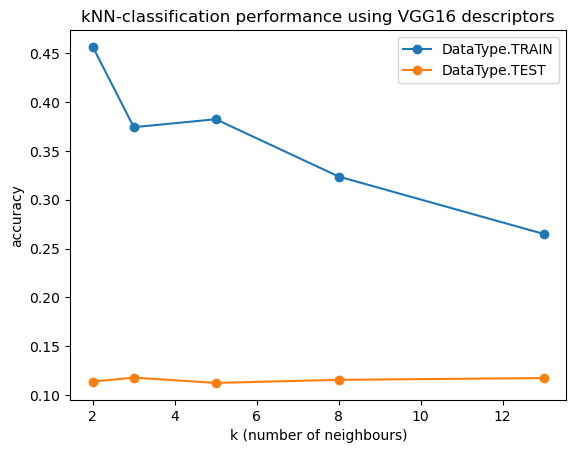

In [20]:
descriptor_assessor.visualise(predictions, accuracies)

### Visually assess predicted vs. target through PCA

In [21]:
best_n_train = max(accuracies[DataType.TRAIN], key=accuracies[DataType.TRAIN].get)
best_n_test = max(accuracies[DataType.TEST], key=accuracies[DataType.TEST].get)
print(best_n_train)
print(best_n_test)

2
3


In [22]:
pca_train = PCA(n_components=best_n_train).fit_transform(descriptors[DataType.TRAIN])
pca_test = PCA(n_components=best_n_test).fit_transform(descriptors[DataType.TEST])

In [23]:
def plot_predictions_against_targets(data,
                                     predictions,
                                     targets,
                                     n_classes,
                                     cmap=None):
    """Draws a scatter plot of two-dimensional data which highlights
    differences between targets and predictions through distinct edge and fill
    colors."""

    if cmap is None:
        cmap = plt.get_cmap("rainbow")

    if isinstance(targets, list):
        targets = np.array(targets)

    colors_target = cmap(targets / n_classes)
    colors_predictions = cmap(predictions / n_classes)

    fig, ax = plt.subplots()
    # Plot targets (ground truth) with fill color representing target class
    ax.scatter(data[:, 0],
               data[:, 1],
               facecolors=colors_target,
               label="target")

    # Plot predictions with edge color representing predicted class
    ax.scatter(data[:, 0],
               data[:, 1],
               facecolors="none",
               edgecolors=colors_predictions,
               label="predicted")

    legend = ax.legend()
    # Set colors to black to indicate the legend is about marker type, rather
    # than color
    legend.legendHandles[0].set_color("black")
    legend.legendHandles[1].set_edgecolor("black")

    return (fig, ax)

Text(0.5, 1.0, 'Two-component PCA, test data')

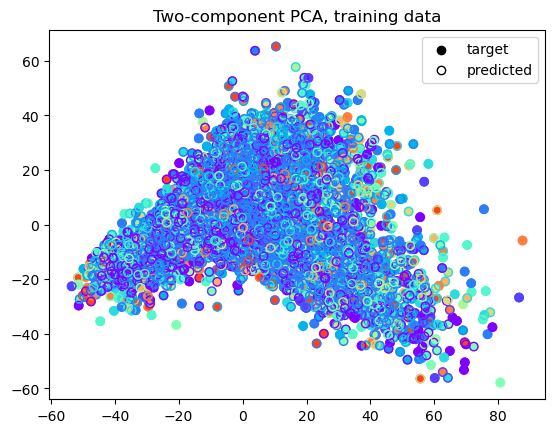

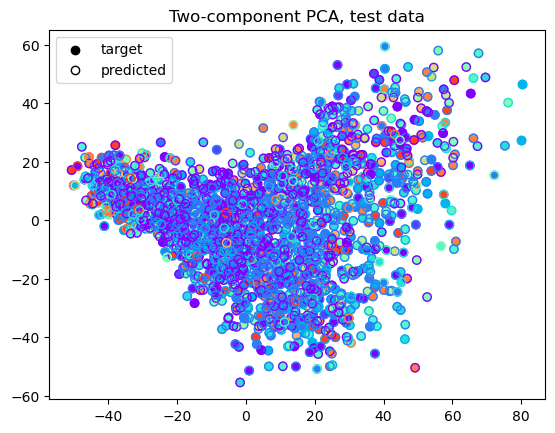

In [24]:
_, ax_train_scatter = plot_predictions_against_targets(pca_train,
                                                       predictions[DataType.TRAIN][best_n_train],
                                                       dataset.targets[DataType.TRAIN],
                                                       len(dataset.all_classes))
ax_train_scatter.set_title("Two-component PCA, training data")

_, ax_test_scatter = plot_predictions_against_targets(pca_test,
                                                      predictions[DataType.TEST][best_n_test],
                                                      dataset.targets[DataType.TEST],
                                                      len(dataset.all_classes))
ax_test_scatter.set_title("Two-component PCA, test data")